# Collecting Heatmaps

# Load Test Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

file_names = ["reduced_class_test_images"]
folder_names = ["test_images"]

for file_name, folder_name in zip(file_names, folder_names):
  # Path to the ZIP file (could be from your Colab environment or Google Drive)
  zip_file_path = f'/content/drive/My Drive/Webcam_Project/datasets/reduced_class_images/{file_name}.zip'

  # Create target directory if it doesn't exist
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)

  # Unzip the file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(folder_name)

  print(f'Files extracted to {folder_name}')

Files extracted to test_images


In [ ]:
!find ./test_images/MISSING -maxdepth 1 -type f | wc -l
!find ./test_images/RAIN_ONLY -maxdepth 1 -type f | wc -l
!find ./test_images/SNOW_ONLY -maxdepth 1 -type f | wc -l

1000
1000
1000


# Load Fine-Tuned Model

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], # Normalize using ImageNet mean and std
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='test_images/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
CLASS_NAMES = ['MISSING', 'RAIN_ONLY', 'SNOW_ONLY']

In [ ]:
test_dataset.classes

['MISSING', 'RAIN_ONLY', 'SNOW_ONLY']

In [ ]:
from torchvision import models
import torch.nn as nn

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Number of features in the last layer of the model
num_ftrs = model.classifier[1].in_features

# Adjust the classifier to your number of classes
# Replace `num_classes` with the actual number of classes
num_classes = len(CLASS_NAMES)  # Assuming 'dataset' is your ImageFolder dataset
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.2MB/s]


In [ ]:
# Path to your saved model weights
model_weights_path = '/content/drive/My Drive/Webcam_Project/model_weights/new_models/mobilenetv2_model_weights.pth'

# Load the weights into the model
model.load_state_dict(torch.load(model_weights_path, map_location=device))

<All keys matched successfully>

# Generate Heatmaps

In [ ]:
# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [ ]:
target_layer = model.features[18]  # Adjusted to target the last Conv2dNormActivation

In [ ]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, input, output):
        self.gradients = output[0]

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        if isinstance(output, tuple):
            output = output[0]
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().to(device)
        one_hot_output[0][torch.argmax(output)] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)
        return output

def generate_heatmap(gradients, activations):
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from PIL import Image
from torchvision import transforms

def overlay_heatmap(img_path, display_img=False, save_path_overlay=None, save_path_cropped=None):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path)

    if display_img:
      cv2_imshow(np.array(img))

    img = transform(img).unsqueeze(0)

    # Move your input tensor to the same device as your model
    img = img.to(device)

    # Assuming grad_cam and generate_heatmap functions are defined and working as intended
    grad_cam = GradCAM(model, target_layer)
    _ = grad_cam(img)

    heatmap = generate_heatmap(grad_cam.gradients, grad_cam.activations)
    heatmap = heatmap.detach().cpu().numpy()

    # Resize the heatmap to match the original image size and create a mask
    original_img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    mask = heatmap_resized > np.percentile(heatmap_resized, 80) # Thresholding to create a mask

    # Convert heatmap to RGB
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # First Overlay: Heatmap over the actual image
    overlay_img = heatmap_color * 0.4 + original_img * 0.6
    overlay_img = np.uint8(overlay_img)

    # Display and save the first overlay
    if display_img:
      cv2_imshow(overlay_img)
    if save_path_overlay is not None:
        cv2.imwrite(save_path_overlay, overlay_img)

    # Second Overlay: Crop to heatmap with neutral background
    cropped_to_heatmap = np.where(mask[..., None], original_img, 255) # Using white (255) as the neutral color

    # Display and save the cropped overlay
    if display_img:
      cv2_imshow(cropped_to_heatmap)
    if save_path_cropped is not None:
        cv2.imwrite(save_path_cropped, cropped_to_heatmap)

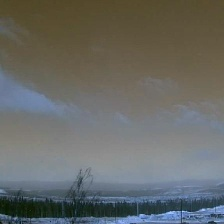

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


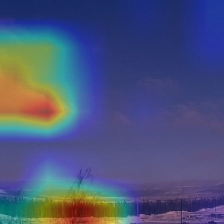

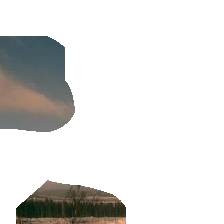

In [ ]:
sample_img_path = "test_images/SNOW_ONLY/CYWK-W-2023_03_10-13_04_30-1.jpg"
overlay_heatmap(sample_img_path, display_img=True)

# Get Evaluation Dataset

In [ ]:
provincial_code = ['AB', 'BC', 'MB', 'NF', 'NS', 'NT', 'NU', 'ON', 'QC', 'YT']
provincial_report = [code + '_ASOS_Matched.csv' for code in provincial_code]

In [ ]:
import pandas as pd
import os

reports = {}

for report, code in zip(provincial_report, provincial_code):
    reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")

<ipython-input-11-1d6ff0ce3159>:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-11-1d6ff0ce3159>:7: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-11-1d6ff0ce3159>:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-11-1d6ff0ce3159>:7: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")


In [ ]:
report_comb = pd.concat([reports[code] for code in reports.keys()], keys=list(reports.keys()))

In [ ]:
report_comb.head()

station             valid  tmpc    dwpc   relh    drct  sknt     mslp  \
AB 0    CYQF  2022-12-16 00:00  -8.0  -11.00  79.00  240.00  5.00  1032.60   
   1    CYQL  2022-12-16 00:00  -6.0   -9.00  79.31  250.00  4.00  1034.00   
   2    CYLL  2022-12-16 00:00 -15.0  -17.00  84.68  280.00  6.00  1030.50   
   3    CYOJ  2022-12-16 00:00 -12.0  -13.00  92.25  180.00  2.00  1028.70   
   4    CYZU  2022-12-16 00:00  -4.0   -7.00  79.62  290.00  4.00  1030.40   

      p01m   vsby  ...   Hail     GS     IP     DZ FZRA/FZDZ  \
AB 0   0.0   9.00  ...  False  False  False  False     False   
   1   0.0  25.00  ...  False  False  False  False     False   
   2   0.0   6.00  ...  False  False  False  False     False   
   3   0.0  10.00  ...  False  False  False  False     False   
   4   0.0  15.00  ...  False  False  False  False     False   

     precipitation_category             valid_dt matched_image_file  \
AB 0                MISSING  2022-12-16 00:00:00                NaN   
   1                MISSING  2022-12-16 00:00:00                NaN   
   2                    NaN  2022-12-16 00:00:00                NaN   
   3              SNOW_ONLY  2022-12-16 00:00:00                NaN   
   4                MISSING  2022-12-16 00:00:00                NaN   

     matched_image_folder p01i  
AB 0                  NaN  NaN  
   1                  NaN  NaN  
   2                  NaN  NaN  
   3                  NaN  NaN  
   4                  NaN  NaN  

[5 rows x 35 columns]

In [ ]:
model.eval()  # Set model to evaluation mode
filename_pred_class_map = {}

with torch.no_grad():  # No gradients needed
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [CLASS_NAMES[pred] for pred in predicted.cpu().numpy()]

        # Assuming test_loader's batch size is constant and samples are not shuffled
        # If there's shuffling, you'll need the actual indices of samples in the batch
        batch_start = i * test_loader.batch_size
        batch_filenames = [filename for filename, _ in test_dataset.samples[batch_start:batch_start+len(inputs)]]

        # Store the filename: predicted class mapping
        for filename, predicted_class in zip(batch_filenames, predicted_classes):
            filename = '-'.join(filename.split('/')[-1].split('.jpg')[0].split('-')[:-1]) + '.jpg'
            filename_pred_class_map[filename] = predicted_class

# At this point, filename_pred_class_map contains the mapping you wanted

In [ ]:
import pandas as pd

def is_valid_float(string):
  try:
    float(string)
    return True
  except ValueError:
    return False

report_comb_filename_to_tmpc_map = {}

map_precipitation_category = {
    'RAIN_ONLY': 'RAIN_ONLY',
    'SNOW_ONLY': 'SNOW_ONLY',
    'MISSING': 'MISSING',
    'RAIN_AND_SNOW': 'SNOW_ONLY',
    'DRIZZLE_ONLY': 'RAIN_ONLY',
    'FREEZING_PRECIP': 'RAIN_ONLY',
}

for index, row in report_comb.iterrows():
    filename = row['matched_image_file']
    tmpc = row['tmpc']
    precipitation_category = row['precipitation_category']
    prediction_category = None

    if filename in filename_pred_class_map:
        prediction_category = filename_pred_class_map[filename]
    else:
      continue

    if precipitation_category in map_precipitation_category:
        precipitation_category = map_precipitation_category[precipitation_category]
    else:
      continue

    if type(tmpc) == str and is_valid_float(tmpc):
        tmpc = float(tmpc)
    else:
        continue

    if not pd.isna(filename) and not pd.isna(tmpc):
      report_comb_filename_to_tmpc_map[filename] = {'tmpc': tmpc, 'precipitation_category': precipitation_category, 'prediction_category': prediction_category}

In [ ]:
for key in list(report_comb_filename_to_tmpc_map.keys())[:20]:
    print(key, report_comb_filename_to_tmpc_map[key]['tmpc'], report_comb_filename_to_tmpc_map[key]['precipitation_category'], report_comb_filename_to_tmpc_map[key]['prediction_category'])

CYOJ-NE-2023_03_15-17_04_30.jpg -16.0 SNOW_ONLY SNOW_ONLY
CYQL-SW-2023_03_17-01_04_30.jpg 0.0 MISSING MISSING
CYQF-W-2023_03_19-21_04_30.jpg 1.0 MISSING MISSING
CYZU-SE-2023_03_21-16_04_30.jpg -7.0 MISSING MISSING
CYZU-SE-2023_03_22-18_04_30.jpg 0.0 MISSING MISSING
CYOJ-NE-2023_03_23-00_04_30.jpg 6.0 MISSING MISSING
CYQF-W-2023_03_25-21_24_30.jpg 2.0 MISSING MISSING
CYOJ-NE-2023_03_26-20_04_30.jpg -9.0 MISSING MISSING
CYOJ-NE-2023_03_27-18_04_30.jpg -9.0 SNOW_ONLY MISSING
CYQF-W-2023_03_27-18_54_30.jpg -6.0 SNOW_ONLY SNOW_ONLY
CYQL-SW-2023_03_27-19_04_30.jpg -5.0 SNOW_ONLY SNOW_ONLY
CYQL-SW-2023_03_28-01_04_30.jpg -5.0 SNOW_ONLY RAIN_ONLY
CYLL-NW-2023_03_28-20_54_30.jpg -4.0 MISSING MISSING
CYQL-SW-2023_03_29-23_04_30.jpg 5.0 MISSING MISSING
CYQL-SW-2023_03_30-13_44_30.jpg -5.0 MISSING MISSING
CYQL-SW-2023_04_01-19_04_30.jpg 10.0 MISSING MISSING
CYOJ-NE-2023_04_01-22_04_30.jpg -4.0 SNOW_ONLY SNOW_ONLY
CYZU-SE-2023_04_02-01_04_30.jpg 6.0 RAIN_ONLY RAIN_ONLY
CYQL-SW-2023_04_02-21_04_30.j

In [ ]:
# Create a dictionary to map index to file name
index_to_filename = {idx: '-'.join(filename.split('/')[-1].split('.jpg')[0].split('-')[:-1]) + '.jpg' for idx, (filename, _) in enumerate(test_dataset.samples)}

# Example usage:
print(index_to_filename[0])  # This will print the file name of the first sample in the dataset

CYAB-SE-2023_03_31-15_04_30.jpg


In [ ]:
print("Filename | Temp | Precip Category | Pred Precip Category")
for filename in list(index_to_filename.values())[:50]:
    if filename in report_comb_filename_to_tmpc_map:
      print(filename, report_comb_filename_to_tmpc_map[filename]['tmpc'], report_comb_filename_to_tmpc_map[filename]['precipitation_category'], report_comb_filename_to_tmpc_map[filename]['prediction_category'])

Filename | Temp | Precip Category | Pred Precip Category
CYBD-SW-2023_01_02-17_04_30.jpg -1.0 MISSING MISSING
CYBD-SW-2023_01_03-19_04_30.jpg 2.0 MISSING MISSING
CYBD-SW-2023_03_01-00_04_30.jpg 3.0 MISSING MISSING
CYBD-SW-2023_04_04-18_04_30.jpg 6.0 MISSING MISSING
CYBD-SW-2023_05_03-18_04_30.jpg 16.0 MISSING MISSING
CYBD-SW-2023_05_09-01_04_30.jpg 19.0 MISSING MISSING
CYBD-SW-2023_05_29-18_54_30.jpg 17.0 MISSING MISSING
CYBD-SW-2023_05_30-18_54_30.jpg 13.0 MISSING MISSING
CYBD-SW-2023_06_09-18_04_30.jpg 19.0 MISSING MISSING
CYBD-SW-2023_08_09-23_04_30.jpg 18.0 MISSING MISSING
CYBD-SW-2023_08_21-16_04_30.jpg 12.0 MISSING MISSING
CYBD-SW-2023_09_06-18_54_30.jpg 16.0 MISSING RAIN_ONLY
CYBD-SW-2023_09_10-21_04_30.jpg 21.0 MISSING MISSING
CYBD-SW-2023_09_14-22_54_30.jpg 21.0 MISSING MISSING
CYBD-SW-2023_09_22-00_04_30.jpg 19.0 MISSING MISSING
CYBD-SW-2023_09_29-22_54_30.jpg 15.0 MISSING MISSING
CYBD-SW-2023_10_11-22_04_30.jpg 15.0 MISSING MISSING
CYBD-SW-2023_10_14-20_54_30.jpg 14.0 MISSIN

In [ ]:
selected_1600_images_info_df = pd.DataFrame(report_comb_filename_to_tmpc_map.values())
selected_1600_images_info_df['filename'] = list(report_comb_filename_to_tmpc_map.keys())

In [ ]:
selected_1600_images_info_df.head()

,tmpc,precipitation_category,prediction_category,filename
0,-16.0,SNOW_ONLY,SNOW_ONLY,CYOJ-NE-2023_03_15-17_04_30.jpg
1,0.0,MISSING,MISSING,CYQL-SW-2023_03_17-01_04_30.jpg
2,1.0,MISSING,MISSING,CYQF-W-2023_03_19-21_04_30.jpg
3,-7.0,MISSING,MISSING,CYZU-SE-2023_03_21-16_04_30.jpg
4,0.0,MISSING,MISSING,CYZU-SE-2023_03_22-18_04_30.jpg


In [ ]:
from google.colab import files

selected_1600_images_info_df.to_csv('selected_1600_images_info.csv', index=False)
files.download('selected_1600_images_info.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate Heatmap for Each Case

In [ ]:
import os

if not os.path.exists('overlay_heatmap_images'):
    os.makedirs('overlay_heatmap_images')
if not os.path.exists('cropped_heatmap_images'):
    os.makedirs('cropped_heatmap_images')

for CLASS_NAME in CLASS_NAMES:
    if not os.path.exists(f'overlay_heatmap_images/{CLASS_NAME}'):
        os.makedirs(f'overlay_heatmap_images/{CLASS_NAME}')
    if not os.path.exists(f'cropped_heatmap_images/{CLASS_NAME}'):
        os.makedirs(f'cropped_heatmap_images/{CLASS_NAME}')

In [ ]:
processible_filenames = []

for filename in list(index_to_filename.values()):
    if filename in report_comb_filename_to_tmpc_map:
      processible_filenames.append(filename)

print(f"Total Processable Files: {len(processible_filenames)}")

Total Processable Files: 1615


In [ ]:
start_idx = 0 # Adjust as needed
end_idx = len(processible_filenames) # Adjust as needed

In [ ]:
%%time
from tqdm import tqdm

for filename in tqdm(processible_filenames[start_idx:end_idx]):
    tmpc = report_comb_filename_to_tmpc_map[filename]['tmpc']
    precipitation_category = report_comb_filename_to_tmpc_map[filename]['precipitation_category']
    prediction_category = report_comb_filename_to_tmpc_map[filename]['prediction_category']

    actual_filename = filename.split('.jpg')[0] + '-1.jpg'

    img_path = f"test_images/{precipitation_category}/{actual_filename}"
    save_path_overlay = f"overlay_heatmap_images/{precipitation_category}/{actual_filename}"
    save_path_cropped = f"cropped_heatmap_images/{precipitation_category}/{actual_filename}"

    overlay_heatmap(
        img_path=img_path,
        display_img=False,
        save_path_overlay=save_path_overlay,
        save_path_cropped=save_path_cropped
    )

  0%|          | 0/115 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 115/115 [00:12<00:00,  8.85it/s]

CPU times: user 14.6 s, sys: 2.57 s, total: 17.1 s
Wall time: 13 s


In [ ]:
!find ./overlay_heatmap_images -type f | wc -l

415


In [ ]:
!zip -r overlay_heatmap_images.zip ./overlay_heatmap_images
!zip -r cropped_heatmap_images.zip ./cropped_heatmap_images

  adding: overlay_heatmap_images/ (stored 0%)
  adding: overlay_heatmap_images/SNOW_ONLY/ (stored 0%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYIV-SE-2023_02_17-19_44_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYRA-E-2023_02_28-17_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYYB-W-2023_02_21-21_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYQB-SW-2023_01_30-08_24_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYIV-SE-2023_02_25-13_24_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYWK-W-2023_12_26-16_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYWK-W-2023_04_03-13_04_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYIV-SE-2023_01_15-20_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYWK-W-2023_03_24-22_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYLK-NE-2023_01_16-20_04_30-1.jpg (deflat

In [ ]:
from google.colab import files

files.download('overlay_heatmap_images.zip')
files.download('cropped_heatmap_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merge Heatmap Datasets

In [ ]:
cropped_heatmap_images_zip_paths = [
    "cropped_heatmap_images_0_to_399.zip",
    "cropped_heatmap_images_400_to_799.zip",
    "cropped_heatmap_images_800_to_1199.zip",
    "cropped_heatmap_images_1200_to_1614.zip",
]
overlay_heatmap_images_zip_paths = [
    "overlay_heatmap_images_0_to_399.zip",
    "overlay_heatmap_images_400_to_799.zip",
    "overlay_heatmap_images_800_to_1199.zip",
    "overlay_heatmap_images_1200_to_1614.zip",
]

In [ ]:
!unzip cropped_heatmap_images_0_to_399.zip
!mv cropped_heatmap_images cropped_heatmap_images_0_to_399
!unzip cropped_heatmap_images_400_to_799.zip
!mv cropped_heatmap_images cropped_heatmap_images_400_to_799
!unzip cropped_heatmap_images_800_to_1199.zip
!mv cropped_heatmap_images cropped_heatmap_images_800_to_1199
!unzip cropped_heatmap_images_1200_to_1614.zip
!mv cropped_heatmap_images cropped_heatmap_images_1200_to_1614
!unzip overlay_heatmap_images_0_to_399.zip
!mv overlay_heatmap_images overlay_heatmap_images_0_to_399
!unzip overlay_heatmap_images_400_to_799.zip
!mv overlay_heatmap_images overlay_heatmap_images_400_to_799
!unzip overlay_heatmap_images_800_to_1199.zip
!mv overlay_heatmap_images overlay_heatmap_images_800_to_1199
!unzip overlay_heatmap_images_1200_to_1614.zip
!mv overlay_heatmap_images overlay_heatmap_images_1200_to_1614

Archive:  cropped_heatmap_images_0_to_399.zip
   creating: cropped_heatmap_images/
   creating: cropped_heatmap_images/SNOW_ONLY/
   creating: cropped_heatmap_images/RAIN_ONLY/
   creating: cropped_heatmap_images/MISSING/
  inflating: cropped_heatmap_images/MISSING/CYFO-SW-2023_03_25-18_04_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYGE-N-2023_06_07-21_04_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYLK-NE-2023_03_15-20_04_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYQL-SW-2023_06_07-19_54_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYIV-SE-2023_07_27-17_04_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYRA-E-2023_07_04-22_54_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYQF-W-2023_06_20-03_24_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYQF-W-2023_07_01-20_54_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYQL-SW-2023_05_07-12_34_30-1.jpg  
  inflating: cropped_heatmap_images/MISSING/CYOJ-NE-2023_03_26

In [ ]:
!mkdir cropped_heatmap_images
!mkdir cropped_heatmap_images/MISSING
!mkdir cropped_heatmap_images/RAIN_ONLY
!mkdir cropped_heatmap_images/SNOW_ONLY
!mkdir overlay_heatmap_images
!mkdir overlay_heatmap_images/MISSING
!mkdir overlay_heatmap_images/RAIN_ONLY
!mkdir overlay_heatmap_images/SNOW_ONLY

In [ ]:
!mv cropped_heatmap_images_0_to_399/MISSING/* cropped_heatmap_images/MISSING/
!mv cropped_heatmap_images_0_to_399/RAIN_ONLY/* cropped_heatmap_images/RAIN_ONLY/
!mv cropped_heatmap_images_0_to_399/SNOW_ONLY/* cropped_heatmap_images/SNOW_ONLY/
!mv cropped_heatmap_images_400_to_799/MISSING/* cropped_heatmap_images/MISSING/
!mv cropped_heatmap_images_400_to_799/RAIN_ONLY/* cropped_heatmap_images/RAIN_ONLY/
!mv cropped_heatmap_images_400_to_799/SNOW_ONLY/* cropped_heatmap_images/SNOW_ONLY/
!mv cropped_heatmap_images_800_to_1199/MISSING/* cropped_heatmap_images/MISSING/
!mv cropped_heatmap_images_800_to_1199/RAIN_ONLY/* cropped_heatmap_images/RAIN_ONLY/
!mv cropped_heatmap_images_800_to_1199/SNOW_ONLY/* cropped_heatmap_images/SNOW_ONLY/
!mv cropped_heatmap_images_1200_to_1614/MISSING/* cropped_heatmap_images/MISSING/
!mv cropped_heatmap_images_1200_to_1614/RAIN_ONLY/* cropped_heatmap_images/RAIN_ONLY/
!mv cropped_heatmap_images_1200_to_1614/SNOW_ONLY/* cropped_heatmap_images/SNOW_ONLY/

mv: cannot stat 'cropped_heatmap_images_0_to_399/RAIN_ONLY/*': No such file or directory
mv: cannot stat 'cropped_heatmap_images_0_to_399/SNOW_ONLY/*': No such file or directory
mv: cannot stat 'cropped_heatmap_images_400_to_799/SNOW_ONLY/*': No such file or directory
mv: cannot stat 'cropped_heatmap_images_800_to_1199/MISSING/*': No such file or directory
mv: cannot stat 'cropped_heatmap_images_1200_to_1614/MISSING/*': No such file or directory
mv: cannot stat 'cropped_heatmap_images_1200_to_1614/RAIN_ONLY/*': No such file or directory


In [ ]:
!mv overlay_heatmap_images_0_to_399/MISSING/* overlay_heatmap_images/MISSING/
!mv overlay_heatmap_images_0_to_399/RAIN_ONLY/* overlay_heatmap_images/RAIN_ONLY/
!mv overlay_heatmap_images_0_to_399/SNOW_ONLY/* overlay_heatmap_images/SNOW_ONLY/
!mv overlay_heatmap_images_400_to_799/MISSING/* overlay_heatmap_images/MISSING/
!mv overlay_heatmap_images_400_to_799/RAIN_ONLY/* overlay_heatmap_images/RAIN_ONLY/
!mv overlay_heatmap_images_400_to_799/SNOW_ONLY/* overlay_heatmap_images/SNOW_ONLY/
!mv overlay_heatmap_images_800_to_1199/MISSING/* overlay_heatmap_images/MISSING/
!mv overlay_heatmap_images_800_to_1199/RAIN_ONLY/* overlay_heatmap_images/RAIN_ONLY/
!mv overlay_heatmap_images_800_to_1199/SNOW_ONLY/* overlay_heatmap_images/SNOW_ONLY/
!mv overlay_heatmap_images_1200_to_1614/MISSING/* overlay_heatmap_images/MISSING/
!mv overlay_heatmap_images_1200_to_1614/RAIN_ONLY/* overlay_heatmap_images/RAIN_ONLY/
!mv overlay_heatmap_images_1200_to_1614/SNOW_ONLY/* overlay_heatmap_images/SNOW_ONLY/

mv: cannot stat 'overlay_heatmap_images_0_to_399/RAIN_ONLY/*': No such file or directory
mv: cannot stat 'overlay_heatmap_images_0_to_399/SNOW_ONLY/*': No such file or directory
mv: cannot stat 'overlay_heatmap_images_400_to_799/SNOW_ONLY/*': No such file or directory
mv: cannot stat 'overlay_heatmap_images_800_to_1199/MISSING/*': No such file or directory
mv: cannot stat 'overlay_heatmap_images_1200_to_1614/MISSING/*': No such file or directory
mv: cannot stat 'overlay_heatmap_images_1200_to_1614/RAIN_ONLY/*': No such file or directory


In [ ]:
!find ./cropped_heatmap_images -type f | wc -l

1615


In [ ]:
!find ./overlay_heatmap_images -type f | wc -l

1615


In [ ]:
!zip -r overlay_heatmap_images.zip ./overlay_heatmap_images
!zip -r cropped_heatmap_images.zip ./cropped_heatmap_images

  adding: overlay_heatmap_images/ (stored 0%)
  adding: overlay_heatmap_images/SNOW_ONLY/ (stored 0%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYWK-W-2023_04_07-19_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYQT-N-2023_02_20-22_14_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYYQ-N-2023_10_31-20_54_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYJF-E-2023_01_10-20_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYQT-N-2023_04_17-22_04_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYFO-SW-2024_01_17-21_44_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYKD-SE-2023_11_07-16_04_30-1.jpg (deflated 1%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYKD-SE-2023_02_21-16_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYQB-SW-2023_03_23-19_04_30-1.jpg (deflated 2%)
  adding: overlay_heatmap_images/SNOW_ONLY/CYYQ-N-2023_11_24-16_24_30-1.jpg (deflate

In [ ]:
from google.colab import files

files.download('overlay_heatmap_images.zip')
files.download('cropped_heatmap_images.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>